In [1]:
from common import *
from process_ntuples import *
from process_df import *
from plotting import *
from cuts import apply_cuts, apply_pt_cut
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping

#weights and biases imports
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback

Welcome to JupyROOT 6.28/00


2023-04-17 04:53:43.179258: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 04:53:44.885102: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


$D^{+}$ : 411

$\Lambda_C^{+}$ : 4122

Apply Cuts Fiducial Region cuts ($𝐷^{+}$ $𝑝_T$ > 8 GeV, |𝜂| < 2.2). ***See cuts.py on how the cuts are applied***

In [2]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[]
Num GPUs Available:  0


2023-04-16 21:17:16.368459: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [2]:
dir_path = "/global/cfs/cdirs/atlas/gottino/Charm/Analysis/run_batch_gup/ntuples"

files = os.listdir(dir_path)

DMesonsTTree = process_ntuple(dir_path, files[0])
LambdaMesonsTTree = process_ntuple(dir_path, files[1])

branches = ["DMesons_pt", "DMesons_eta", "DMesons_m", "DMesons_fitOutput__Lxy", "DMesons_costhetastar", "DMesons_pdgId"]

print(files)

['CharmAnalysis.mc.ForcedDecay.Dplus.tree.root', 'CharmAnalysis.mc.ForcedDecay.LabmdaC.tree.root']


In [4]:
branches = ["DMesons_pt", "DMesons_eta", "DMesons_m", "DMesons_fitOutput__Lxy", "DMesons_costhetastar", "DMesons_pdgId"]
DMesons_df = show(0, DMesonsTTree, branches, 0)
DMesons_df = remove_empty(DMesons_df)

DMesons_df["DMesons_pt"] = DMesons_df["DMesons_pt"].apply(divide_by_1000)
for col in DMesons_df.columns:
    DMesons_df[col] = DMesons_df[col].apply(list)
DMesons_df = apply_cuts(DMesons_df)

In [5]:
DMesons_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId
0,[10.047125],[0.08182407170534134],[1862.4176025390625],[2.3395302295684814],[0.25487038493156433],[411]
1,"[18.9937421875, 18.9937421875]","[-1.6619627475738525, -1.6619627475738525]","[1853.90625, 2398.886962890625]","[1.9184143543243408, 1.9184143543243408]","[-0.36730244755744934, -0.0650731548666954]","[411, 4122]"
2,"[10.118494140625, 10.118494140625]","[0.041659336537122726, 0.041659336537122726]","[1874.203125, 2468.1806640625]","[2.8901257514953613, 2.8901257514953613]","[0.06833142042160034, 0.4276972711086273]","[411, 4122]"
3,"[12.579470703125, 12.579470703125]","[-1.1025604009628296, -1.1025604009628296]","[1884.987060546875, 2220.384521484375]","[0.9249186515808105, 0.9249186515808105]","[-0.5603189468383789, -0.41332852840423584]","[411, 4122]"
4,[36.1288359375],[0.6598162055015564],[2235.69873046875],[0.3584118187427521],[0.19036155939102173],[4122]
...,...,...,...,...,...,...
8235046,[17.96],[-0.6264557838439941],[1865.6043701171875],[5.87862491607666],[0.45278045535087585],[411]
8235047,"[62.91061328125, 62.91061328125]","[0.2775037884712219, 0.2775037884712219]","[1847.262451171875, 2131.1259765625]","[11.870012283325195, 11.870012283325195]","[-0.9544855356216431, -0.9355815052986145]","[411, 4122]"
8235048,"[14.8181767578125, 14.8181767578125]","[-2.1479332447052, -2.1479332447052]","[1836.0997314453125, 2165.72412109375]","[2.027026653289795, 2.027026653289795]","[-0.9712575674057007, -0.9517184495925903]","[411, 4122]"
8235049,[39.3814296875],[1.5503557920455933],[2210.86669921875],[0.17065481841564178],[-0.332907497882843],[4122]


In [23]:
# DMesons_df = generate_df(DMesonsTTree, branches, 100)
# DMesons_df = apply_cuts(DMesons_df)
# DMesons_df

In [24]:
# Lambda_df = generate_df(LambdaMesonsTTree, branches, 100)
# Lambda_df = apply_cuts(Lambda_df)
# Lambda_df

In [2]:
DMesons_df = load("DMesons_df")
DMesons_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId
0,[10.047125],[0.08182407170534134],[1862.4176025390625],[2.3395302295684814],[0.25487038493156433],[411]
1,"[18.9937421875, 18.9937421875]","[-1.6619627475738525, -1.6619627475738525]","[1853.90625, 2398.886962890625]","[1.9184143543243408, 1.9184143543243408]","[-0.36730244755744934, -0.0650731548666954]","[411, 4122]"
2,"[10.118494140625, 10.118494140625]","[0.041659336537122726, 0.041659336537122726]","[1874.203125, 2468.1806640625]","[2.8901257514953613, 2.8901257514953613]","[0.06833142042160034, 0.4276972711086273]","[411, 4122]"
3,"[12.579470703125, 12.579470703125]","[-1.1025604009628296, -1.1025604009628296]","[1884.987060546875, 2220.384521484375]","[0.9249186515808105, 0.9249186515808105]","[-0.5603189468383789, -0.41332852840423584]","[411, 4122]"
4,[36.1288359375],[0.6598162055015564],[2235.69873046875],[0.3584118187427521],[0.19036155939102173],[4122]
...,...,...,...,...,...,...
7417090,[17.96],[-0.6264557838439941],[1865.6043701171875],[5.87862491607666],[0.45278045535087585],[411]
7417091,"[62.91061328125, 62.91061328125]","[0.2775037884712219, 0.2775037884712219]","[1847.262451171875, 2131.1259765625]","[11.870012283325195, 11.870012283325195]","[-0.9544855356216431, -0.9355815052986145]","[411, 4122]"
7417092,"[14.8181767578125, 14.8181767578125]","[-2.1479332447052, -2.1479332447052]","[1836.0997314453125, 2165.72412109375]","[2.027026653289795, 2.027026653289795]","[-0.9712575674057007, -0.9517184495925903]","[411, 4122]"
7417093,[39.3814296875],[1.5503557920455933],[2210.86669921875],[0.17065481841564178],[-0.332907497882843],[4122]


In [3]:
DMesons_df = remove_duplicates(DMesons_df)

Removed 0 duplicate particles


In [4]:
DMesons_df = DMesons_df.head(1000000)

In [6]:
#separates each particle of the event into it's own event in a new data frame (for training)
dfs = []
for index, row in DMesons_df.iterrows():
    
    pts = row['DMesons_pt']
    etas = row['DMesons_eta']
    ms = row['DMesons_m']
    lxys = row['DMesons_fitOutput__Lxy']
    costhetastars = row['DMesons_costhetastar']
    pdgids = row["DMesons_pdgId"]
        
    d = {DMesons_df.columns[0]: pts, DMesons_df.columns[1]: etas, DMesons_df.columns[2]: ms, DMesons_df.columns[3]: lxys, 
         DMesons_df.columns[4]: costhetastars, DMesons_df.columns[-1]: pdgids}
    df = pd.DataFrame(data=d)
    
    dfs.append(df)

df = pd.concat(dfs)
df = df.reset_index(drop = True)
df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId
0,10.047125,0.081824,1862.417603,2.339530,0.254870,411
1,18.993742,-1.661963,1853.906250,1.918414,-0.367302,411
2,18.993742,-1.661963,2398.886963,1.918414,-0.065073,4122
3,10.118494,0.041659,1874.203125,2.890126,0.068331,411
4,10.118494,0.041659,2468.180664,2.890126,0.427697,4122
...,...,...,...,...,...,...
1660074,12.158312,0.132812,1869.685547,0.588506,0.557646,411
1660075,12.158312,0.132812,2280.860107,0.588506,0.823664,4122
1660076,8.233737,0.773861,1875.938477,1.890014,0.976978,411
1660077,39.016086,1.315515,1884.218384,2.228456,0.830586,411


In [ ]:
DMesons_df2 = show(0, TTree, ["DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId"], 100)
DMesons_df2 = remove_empty(DMesons_df2)

In [59]:
DPlus = [-321, 211, 211]
LambdaC = [2212, -321, 211]

remove_lambda = []

count = 0
for index, row in DMesons_df2.iterrows():
    if count == 50:
        break
    count+=1
    
    pts = row['DMesons_daughterInfo__pt']
    etas = row['DMesons_daughterInfo__eta']
    phis = row['DMesons_daughterInfo__phi']
    pdgids = row["DMesons_daughterInfo__pdgId"]
    
    #loop through until the first lambda encountered
    for i in range(len(pdgids) - 1):
        #if there are multiple lambda baryons
        if len(pdgids) > 2:
            #stop at the first lambda and keep the higher proton pt valued lambda
            if list(pdgids[i]) == LambdaC:
                l1_pt, l2_pt = pts[i][0], pts[i + 1][0]
                if (l1_pt > l2_pt):
                    #Lambda 1's proton has higher pt
                    remove_lambda.append((index, i + 1))
                elif (l1_pt < l2_pt):
                    #Lambda 2's proton has higher pt!
                    remove_lambda.append((index, i))
                else:
                    raise Exception("Error: Are the proton pt vaules equal?")
                    
len(remove_lambda)

3

In [24]:
#takes tuples of shape (2,) / (index, column)
def remove_particles_from_df(df, tuple_list):
    for tup in tuple_list:
        index, column = tup
        print(index, column)
        
        new_df = df.copy()
        for i in range(len(DMesons_df.iloc[index, 0][column]) + 1):
            #new_df["DMesons_daughterInfo__pt"] = new_df["DMesons_daughterInfo__pt"].apply(lambda x: print(x))
            val = new_df.iloc[index, i][column]
            print(val)
    df = df.drop(index, axis = 0)
    return df
#df = remove_particles_from_df(DMesons_df, remove_lambda)

pd.set_option('display.max_rows', 10)

In [29]:
# create a new column 'particle_type' based on the pdgId column
#func = lambda x: 'only_411' if x == [411] else ('only_4122' if x == [4122] else 'both')

def func(x):
    if x == 411:
        return 'only_411'
    elif x == 4122:
        return 'only_4122'
    else:
        return "both"

shuffled_df['particle_type'] = shuffled_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = shuffled_df[shuffled_df['particle_type'] == 'only_411']
only_4122 = shuffled_df[shuffled_df['particle_type'] == 'only_4122']
#both = DMesons_df[DMesons_df['particle_type'] == 'both']

new_df = shuffled_df[shuffled_df['particle_type'] != 'both']
new_df = new_df.reset_index(drop=True)

new_df.loc[:, 'DMesons_pt'] = new_df['DMesons_pt'].apply(lambda x: float(x))
new_df.loc[:, 'DMesons_eta'] = new_df['DMesons_eta'].apply(lambda x: float(x))
#new_df.loc[:, 'DMesons_m'] = new_df['DMesons_m'].apply(lambda x: float(x))
new_df.loc[:, 'DMesons_fitOutput__Lxy'] = new_df['DMesons_fitOutput__Lxy'].apply(lambda x: float(x))
new_df.loc[:, 'DMesons_costhetastar'] = new_df['DMesons_costhetastar'].apply(lambda x: float(x))
new_df.loc[:, 'DMesons_pdgId'] = new_df['DMesons_pdgId'].apply(lambda x: int(x))
new_df = new_df.drop('particle_type', axis=1)

In [8]:
D = 0
Lambda = 0
for pdgId in new_df["DMesons_pdgId"]:
    if pdgId == 411:
        D+=1
    elif pdgId == 4122:
        Lambda+=1
print(D, Lambda)

846608 811534


In [9]:
# only_411 = only_411.reset_index(drop=True)
# only_411.loc[:, 'DMesons_pt'] = only_411['DMesons_pt'].apply(lambda x: float(x[0]))
# only_411.loc[:, 'DMesons_eta'] = only_411['DMesons_eta'].apply(lambda x: float(x[0]))
# only_411.loc[:, 'DMesons_m'] = only_411['DMesons_m'].apply(lambda x: float(x[0]))
# only_411.loc[:, 'DMesons_fitOutput__Lxy'] = only_411['DMesons_fitOutput__Lxy'].apply(lambda x: float(x[0]))
# only_411.loc[:, 'DMesons_costhetastar'] = only_411['DMesons_costhetastar'].apply(lambda x: float(x[0]))
# only_411.loc[:, 'DMesons_pdgId'] = only_411['DMesons_pdgId'].apply(lambda x: int(x[0]))
only_411 = only_411.drop('particle_type', axis=1)

# only_4122 = only_4122.reset_index(drop=True)
# only_4122.loc[:, 'DMesons_pt'] = only_4122['DMesons_pt'].apply(lambda x: float(x[0]))
# only_4122.loc[:, 'DMesons_eta'] = only_4122['DMesons_eta'].apply(lambda x: float(x[0]))
# only_4122.loc[:, 'DMesons_m'] = only_4122['DMesons_m'].apply(lambda x: float(x[0]))
# only_4122.loc[:, 'DMesons_fitOutput__Lxy'] = only_4122['DMesons_fitOutput__Lxy'].apply(lambda x: float(x[0]))
# only_4122.loc[:, 'DMesons_costhetastar'] = only_4122['DMesons_costhetastar'].apply(lambda x: float(x[0]))
# only_4122.loc[:, 'DMesons_pdgId'] = only_4122['DMesons_pdgId'].apply(lambda x: int(x[0]))
only_4122 = only_4122.drop('particle_type', axis=1)

#new_df = new_df.drop('DMesons_m', axis=1)
only_411 = only_411.drop('DMesons_m', axis=1)
only_4122 = only_4122.drop('DMesons_m', axis=1)

In [12]:
only_4122

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId
2,18.993742,-1.661963,1.918414,-0.065073,4122
4,10.118494,0.041659,2.890126,0.427697,4122
6,12.579471,-1.102560,0.924919,-0.413329,4122
7,36.128836,0.659816,0.358412,0.190362,4122
9,15.020291,-0.034316,1.028398,0.067321,4122
...,...,...,...,...,...
1660068,10.548007,1.538961,1.138265,-0.198148,4122
1660070,11.152401,-0.025487,1.273141,0.740452,4122
1660072,8.283731,1.182054,1.952910,0.662747,4122
1660075,12.158312,0.132812,0.588506,0.823664,4122


In [13]:
# Write
# save(new_df, "DMesons_df_both")
# save(only_411, "DMesons_only_411")
# save(only_4122, "DMesons_only_4122")

In [14]:
# Read
# both_df = load("Lambda_df_both")
# only_411 = load("Lambda_only_411")
Lambda_only_4122 = load("Lambda_only_4122")
DMesons_only_411 = load("DMesons_only_411")

In [24]:
Lambda_only_4122 = Lambda_only_4122.head(500000)
DMesons_only_411 = DMesons_only_411.head(500000)

combined_df = pd.concat([Lambda_only_4122, DMesons_only_411], axis=0)

# Shuffle the rows of the combined data frame
shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)

In [25]:
shuffled_df

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId
0,12.854837,-1.539683,0.174197,-0.722699,4122
1,16.744395,-0.755727,0.167661,-0.546451,4122
2,8.290655,0.978280,0.696047,-0.162192,411
3,12.104251,0.239708,0.348673,0.845879,4122
4,9.491051,1.801929,1.421223,-0.410588,411
...,...,...,...,...,...
999995,33.471316,-0.330418,0.250487,-0.909678,4122
999996,17.177361,0.259101,0.435482,0.054576,4122
999997,31.237898,0.942365,3.536297,0.308264,411
999998,15.576171,1.740996,0.408398,-0.936816,4122


In [27]:
D = 0
Lambda = 0
for pdgId in shuffled_df["DMesons_pdgId"]:
    if pdgId == 411:
        D+=1
    elif pdgId == 4122:
        Lambda+=1
print(D, Lambda)

500000 500000


In [31]:
new_df

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId
0,12.854837,-1.539683,0.174197,-0.722699,4122
1,16.744395,-0.755727,0.167661,-0.546451,4122
2,8.290655,0.978280,0.696047,-0.162192,411
3,12.104251,0.239708,0.348673,0.845879,4122
4,9.491051,1.801929,1.421223,-0.410588,411
...,...,...,...,...,...
999995,33.471316,-0.330418,0.250487,-0.909678,4122
999996,17.177361,0.259101,0.435482,0.054576,4122
999997,31.237898,0.942365,3.536297,0.308264,411
999998,15.576171,1.740996,0.408398,-0.936816,4122


In [33]:
#D and Lambda
new_df['DMesons_pdgId'] = new_df['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train, X_test, y_train, y_test = train_test_split(new_df[['DMesons_pt','DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar']], new_df['DMesons_pdgId'], test_size=0.2, random_state=42)

#only DMesons
only_411['DMesons_pdgId'] = only_411['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train1, X_test1, y_train1, y_test1 = train_test_split(only_411[['DMesons_pt', 'DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar']], only_411['DMesons_pdgId'], test_size=0.2, random_state=42)

#only Lambda
only_4122['DMesons_pdgId'] = only_4122['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train2, X_test2, y_train2, y_test2 = train_test_split(only_4122[['DMesons_pt', 'DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar']], only_4122['DMesons_pdgId'], test_size=0.2, random_state=42)

/tmp/ipykernel_4271/425015357.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_411['DMesons_pdgId'] = only_411['DMesons_pdgId'].replace({411: 0, 4122: 1})
/tmp/ipykernel_4271/425015357.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_4122['DMesons_pdgId'] = only_4122['DMesons_pdgId'].replace({411: 0, 4122: 1})


In [34]:
print(np.shape(X_train), np.shape(X_test))

X_train

(800000, 4) (200000, 4)


,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar
566853,22.207609,1.183481,1.473966,-0.477021
382311,21.409330,0.612875,2.294402,-0.554615
241519,22.040375,-0.339768,2.042228,-0.266927
719220,18.944838,-1.237723,0.872269,-0.413799
905718,19.949635,-0.033579,0.415056,0.967797
...,...,...,...,...
259178,10.120765,0.303242,0.366170,0.673468
365838,66.956469,-0.441359,1.449622,-0.999518
131932,22.212793,1.177263,10.502167,0.707723
671155,30.752645,-2.197569,7.909176,0.441913


In [21]:
#Write to disk
# with open('DMesons_ready.pickle', 'wb') as f:
#     pickle.dump(new_df, f)

# with open('only_411.pickle', 'wb') as f:
#     pickle.dump(only_411, f)
    
# with open('only_4122.pickle', 'wb') as f:
#     pickle.dump(only_4122, f)

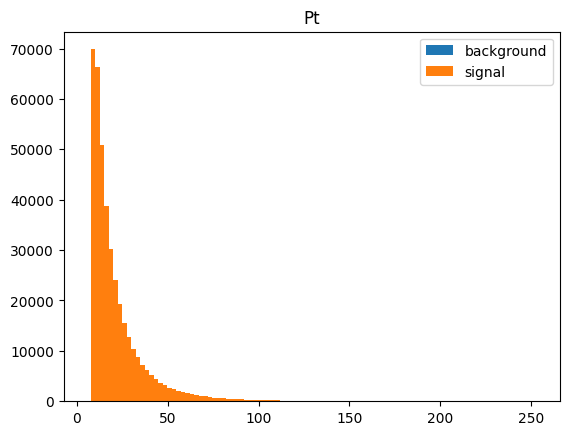

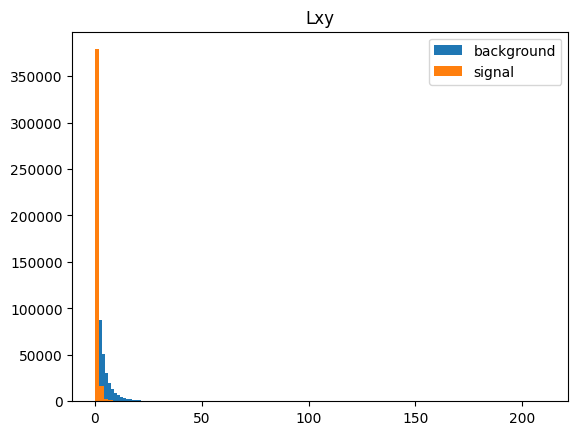

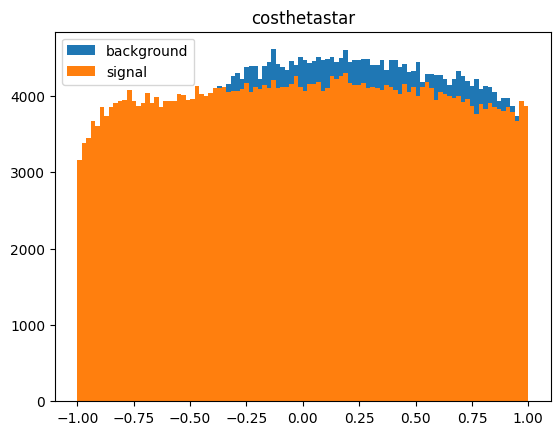

In [35]:
plt.figure()
plt.title("Pt")
hists = plt.hist(X_train1["DMesons_pt"], bins = 100, label = "background", alpha=0.5)
hists = plt.hist(X_train2["DMesons_pt"], bins = 100, label = "signal", alpha=0.5)
plt.legend()
plt.show()

plt.figure()
plt.title("Lxy")
hists1 = plt.hist(X_train1["DMesons_fitOutput__Lxy"], bins = 100, label = "background")
hists1 = plt.hist(X_train2["DMesons_fitOutput__Lxy"], bins = 100, label = "signal")
plt.legend()
plt.show()

plt.figure()
plt.title("costhetastar")
hists2 = plt.hist(X_train1["DMesons_costhetastar"], bins = 100, label = "background")
hists2 = plt.hist(X_train2["DMesons_costhetastar"], bins = 100, label = "signal")
plt.legend()
plt.show()

#density = counts / (sum(counts) * np.diff(bins))
# plt.legend()
# plt.show()

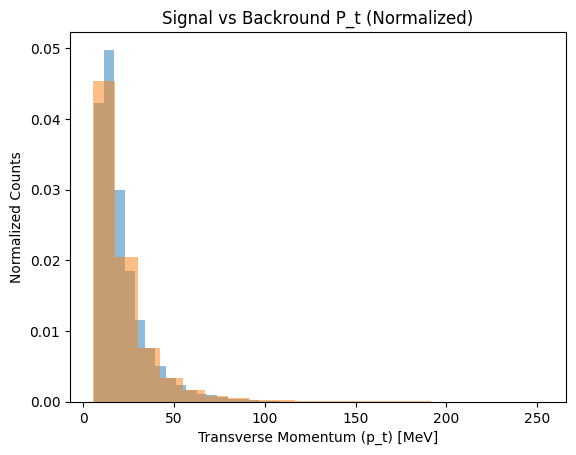

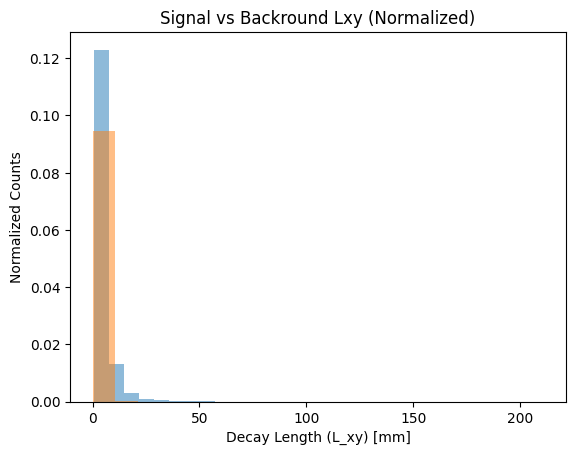

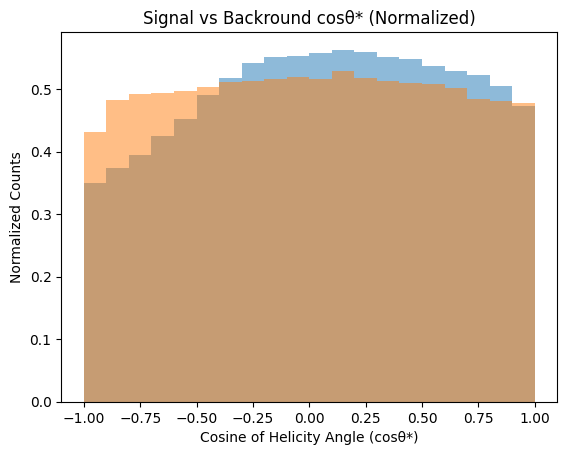

In [58]:
counts, bins, _ = plt.hist(X_train1["DMesons_pt"], bins=20)
counts2, bins2, _ = plt.hist(X_train2["DMesons_pt"], bins=20)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5)
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5)
plt.title("Signal vs Backround P_t (Normalized)")
plt.xlabel("Transverse Momentum (p_t) [MeV]")
plt.ylabel("Normalized Counts")
plt.show()

counts, bins, _ = plt.hist(X_train1["DMesons_fitOutput__Lxy"], bins=20)
counts2, bins2, _ = plt.hist(X_train2["DMesons_fitOutput__Lxy"], bins=20)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5)
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5)
plt.title("Signal vs Backround Lxy (Normalized)")
plt.xlabel("Decay Length (L_xy) [mm]")
plt.ylabel("Normalized Counts")
plt.show()

counts, bins, _ = plt.hist(X_train1["DMesons_costhetastar"], bins=20)
counts2, bins2, _ = plt.hist(X_train2["DMesons_costhetastar"], bins=20)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5)
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5)
plt.title("Signal vs Backround cosθ* (Normalized)")
plt.xlabel("Cosine of Helicity Angle (cosθ*)")
plt.ylabel("Normalized Counts")
plt.show()

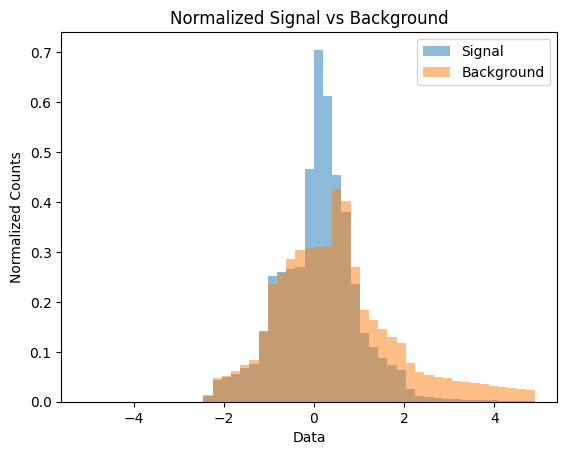

In [52]:
#counts, bins, _ = plt.hist(X_train1, bins=20)
bins = np.linspace(-5, 5, 50)
signal_counts, _ = np.histogram(X_train2, bins=bins, density=True)
background_counts, _ = np.histogram(X_train1, bins=bins, density=True)

# Plot the signal and background histograms on the same plot
plt.bar(bins[:-1], signal_counts, width=np.diff(bins), alpha=0.5, label='Signal')
plt.bar(bins[:-1], background_counts, width=np.diff(bins), alpha=0.5, label='Background')

# Add axis labels and a legend
plt.xlabel('Data')
plt.ylabel('Normalized Counts')
plt.title("Normalized Signal vs Background")
plt.legend()

# Show the plot
plt.show()

In [36]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ATLAS_DNN",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 64,
        "activation_1": "relu",
        "dropout_1": 0.5,
        "layer_2": 32,
        "activation_2": "relu",
        "dropout_2": 0.5,
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 10,
        "batch_size": 32
    }
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gup-singh (atlasdnn). Use `wandb login --relogin` to force relogin


In [37]:
# def get_config(self):
#     return config

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        config = wandb.config
        self.dense1 = Dense(config.layer_1, activation=config.activation_1)
        self.dropout1 = Dropout(config.dropout_1)
        
        self.dense2 = Dense(config.layer_2, activation = config.activation_2)
        self.dropout2 = Dropout(config.dropout_2)
        
        self.dense3 = Dense(config.output_layer, activation=config.output_activation)
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dropout1(x)
        
        x = self.dense2(x)
        x = self.dropout2(x)
        
        x = self.dense3(x)
        
        return x
    
model = MyModel()
model.build(input_shape=(None, X_train.shape[1]))
model.summary()

#def custom_accuracy()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  320       
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  2080      
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  33        
                                                                 
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
_________________________________________________________________


2023-04-17 05:15:52.339632: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [38]:
#Compile
import time

start_time = time.time()

model.compile(optimizer=config.optimizer, loss=config.loss)

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
#Train
history = model.fit(X_train, y_train, epochs=config.epoch, batch_size=config.batch_size, validation_data=(X_test, y_test), callbacks=[early_stop, WandbCallback(), tf.keras.callbacks.History()])

#Evaluate testing set
loss = model.evaluate(X_test, y_test)
print("Loss: {}".format(loss))

end_time = time.time()
runtime = end_time - start_time
print("Training runtime:", runtime, "seconds")

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
24964/25000 [============================>.] - ETA: 0s - loss: 0.3358

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230417_051536-bd1osg95/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230417_051536-bd1osg95/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230417_051536-bd1osg95/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 41s 2ms/step - loss: 0.3357 - val_loss: 0.2918
Epoch 2/10
25000/25000 [==============================] - 39s 2ms/step - loss: 0.3067 - val_loss: 0.2961
Epoch 3/10
24993/25000 [============================>.] - ETA: 0s - loss: 0.3042

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230417_051536-bd1osg95/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230417_051536-bd1osg95/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230417_051536-bd1osg95/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 40s 2ms/step - loss: 0.3042 - val_loss: 0.2915
Epoch 4/10
24993/25000 [============================>.] - ETA: 0s - loss: 0.3040

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230417_051536-bd1osg95/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230417_051536-bd1osg95/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230417_051536-bd1osg95/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 40s 2ms/step - loss: 0.3040 - val_loss: 0.2887
Epoch 5/10
25000/25000 [==============================] - 39s 2ms/step - loss: 0.3025 - val_loss: 0.2919
Epoch 6/10
25000/25000 [==============================] - 39s 2ms/step - loss: 0.3025 - val_loss: 0.2905
Epoch 7/10
25000/25000 [==============================] - 40s 2ms/step - loss: 0.3020 - val_loss: 0.2898
Epoch 7: early stopping
6250/6250 [==============================] - 7s 1ms/step - loss: 0.2898
Loss: 0.2897971272468567
Training runtime: 286.04940366744995 seconds


2023-04-17 05:17:12.130009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-17 05:17:12.145992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-04-17 05:17:12.351547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-17 05:17:12

In [39]:
wandb.finish()

epoch,▁▂▃▅▆▇█
loss,█▂▁▁▁▁▁
val_loss,▄█▄▁▄▃▂
best_epoch,3
best_val_loss,0.28874
epoch,6
loss,0.30196
val_loss,0.2898


------------------------------------------ Finished training, now analyze ------------------------------------------

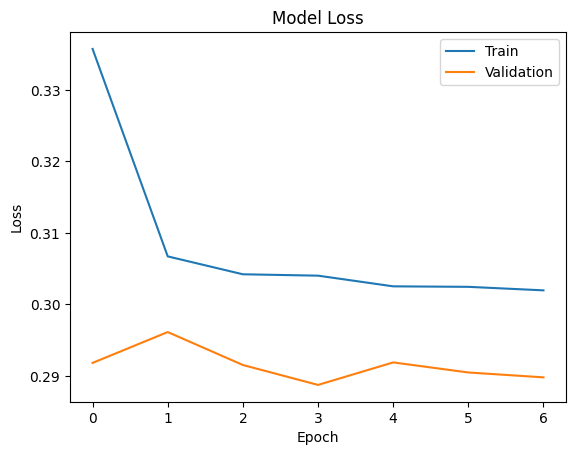

In [40]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [41]:
predictions = model.predict(X_test)
predictions[:10]

6250/6250 [==============================] - 6s 1ms/step


array([[0.63969845],
       [1.        ],
       [0.6093097 ],
       [1.        ],
       [0.09878346],
       [0.21069054],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.7404967 ]], dtype=float32)

In [42]:
predictions1 = model.predict(X_test1)
predictions1[:10]

3125/3125 [==============================] - 3s 968us/step


array([[4.2188942e-01],
       [8.7117150e-02],
       [1.1994354e-10],
       [9.0365519e-04],
       [7.7673460e-05],
       [3.1168243e-01],
       [3.7656406e-01],
       [9.9666743e-03],
       [2.9376862e-04],
       [6.1678332e-01]], dtype=float32)

In [43]:
predictions2 = model.predict(X_test2)
predictions2[:10]

3125/3125 [==============================] - 3s 985us/step


array([[0.9987517 ],
       [1.        ],
       [0.1342389 ],
       [0.7593565 ],
       [1.        ],
       [1.        ],
       [0.5937882 ],
       [0.9993856 ],
       [0.60715353],
       [0.9992397 ]], dtype=float32)

In [44]:
predictions_list = []
D_count = 0
Lambda_count = 0
unclear = 0
for pred in predictions:
    if float(pred) > 0.7:
        predictions_list.append(int(1))
        Lambda_count+=1
    elif float(pred) < 0.7:
        predictions_list.append(int(0))
        D_count+=1
    else:
        unclear+=1
        
print("$D^+$ Count: {}".format(D_count))
print("$\Lambda_C^+ Count: {}".format(Lambda_count))
print("Unknown Particle Count: {}".format(unclear))
np.shape(predictions)

$D^+$ Count: 136193
$\Lambda_C^+ Count: 63807
Unknown Particle Count: 0


(200000, 1)

In [45]:
accuracy = np.mean(predictions_list == y_test)
print("Accuracy: {:.2%}".format(accuracy))

y_test

Accuracy: 80.55%


987231    1
79954     1
567130    1
500891    1
55399     0
         ..
90245     1
639296    1
311939    1
324459    1
390499    1
Name: DMesons_pdgId, Length: 200000, dtype: int64

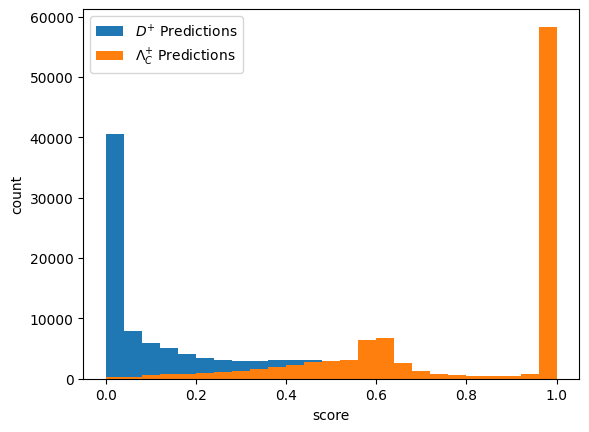

In [46]:
hist = plt.hist(predictions1, bins = 25, label = "$D^{+}$ Predictions")
hist2 = plt.hist(predictions2, bins = 25, label = "$\Lambda_C^{+}$ Predictions")
plt.xlabel("score")
plt.ylabel("count")
plt.legend()
plt.show()

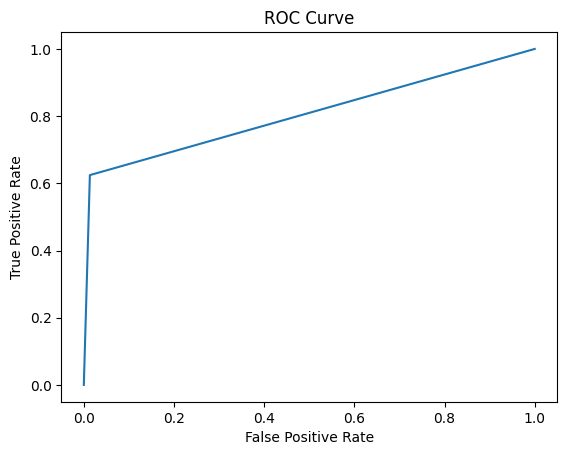

In [47]:
from sklearn.metrics import roc_curve

# Get true labels and predicted probabilities
y_true = y_test
y_pred = predictions_list

# Calculate TPR and FPR for different threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
